<a href="https://colab.research.google.com/github/teerasitk/signalProcessingInFinance/blob/main/Assignment06_TradeUsingLinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
This assignment goal is to allow students to be creative on how to use tools that we have just learnt in the class to maximize his or her profit. There are two goals that students should achieve
1. Understand the uses of ARMA, ARIMA, ARCH and GRACH Models
2. Develop his or her trading strategy to maximize his or her gain.

## Import and Install related libraies

In [17]:
!pip install yfinance
!pip install arch
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import itertools    
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import arch
from typing import Union, Any, Tuple, Literal
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ARIMA Seach Module

In [10]:
def arimaParameterSearch(data:pd.Series, ## input date
                         pq_order:int =2, # maximum AR and MA orders
                         d_order: int =1 # maximum d order
                         ) -> Tuple[float, tuple, callable]:
                         # aic value, (p,d,q), result of model
  p = q = range(pq_order) # p =q = [0,1,..., pq_order-1]
  d = range(d_order) # d = [0,1,..., d_order-1]
  parameter_spaces = list(itertools.product(p, d, q)) 
  # all possible pairs of (p, d, q)
  best_aic, pdq= None, None
  best_result = None
  for (p, d, q) in parameter_spaces:   # for each pair
    try :
      model = SARIMAX(data, order=(p,d,q), trend="c") # initialize model
      result = model.fit() # find best parameters
      if (best_aic is None) or (result.aic < best_aic): # if aic is smaller
        best_aic = result.aic # update model, aic, and pqq
        pdq = (p,d,q)
        best_result = result
    except:
      continue
  return best_aic, pdq, best_result

## ARCH Seach Module

In [25]:
from arch.univariate.base import ARCHModel, ARCHModelResult
warnings.filterwarnings("ignore")
def buildArch(data:pd.Series, # input date
              p_max:int=10, # maximum arch terms
              mean_type:Literal["zero","constant","AR"]="constant" # possible mean function
              ) -> Tuple[ARCHModelResult, ARCHModel, int]:
              # result from model fit and the model
  best_aic = 1e200
  best_model = None
  best_result = None
  for p in range(1, p_max): # for p from 1 to p_max -1 
    for lag in range(p):
      model = arch_model(data, 
                         mean=mean_type,                         
                         p=p, 
                         q=0, 
                         vol="ARCH")
      try:
        result = model.fit(disp=False)
        aic = result.aic
        if aic < best_aic:
          best_aic = aic
          best_model = model
          best_result = result
          best_p = p
      except:
        continue      
  return best_result, best_model, best_p


## GARCH Seach Module

In [26]:
def buildGArch(data:pd.Series, # input date
               p_max:int=10, # maximum residue terms,
               q_max:int=10, # maximum sigma terms
               mean_type:Literal["zero","constant","AR"]="constant" # possible mean function
               ) -> Tuple[ARCHModelResult, ARCHModel, tuple]:
  best_aic = 1e200
  best_model = None
  best_result = None
  p_list = range(1, p_max)
  q_list = range(0, q_max)
  pq_garch = (0,0)
  parameter_spaces = list(itertools.product(p_list, q_list)) 
  for (p, q) in parameter_spaces:
    model = arch_model(data, mean=mean_type,
                       p=p, q=q, vol="GARCH")
    try:
      result = model.fit(disp=False)
      aic = result.aic
      if aic < best_aic:
        best_aic = aic
        best_model = model
        best_result = result
        pq_garch  =(p,q)
    except:
      continue      
  return best_result, best_model, pq_garch

## Action and Status Module

In [27]:
class Status:
  HOLD = "HOLD"
  NO_POSITION = "NO POSITION"
class Action:
  BUY = "BUY"
  SELL = "SELL"
  KEEP_POSITION = "KEEP POSITION"

## Decision Module

Here, I used the fact that rapid change in price may cause by the market participation. 
 1. Buy if the upper bound price (highest_price ) is lower than current price. The rapid increase in the current price comparing to the forecasted upper bound value show that the market rushes to buy bitcoin and the price should continue to move up. 
 2. Sell if the lower bound price (lowest_pice) is higher than current price or buy_price is lower than 95% of current_price. (set maximum loss at 95%). Rapid decrease in current price comparing to lower bound price shows that market moves away from the bitcoin.

In [53]:
def makeDecisionARIMA(data: pd.Series, # hist_price
                      current_price: float, # current_price
                      buy_price:float, # last_buy_price
                      status: str, # hold or no position
                      pq:Union[tuple,int], # tuple for fix size and int to search for optm. param
                      d:int, # either the integration term or maximum search value
                      look_forward:int=1 # how far into the future
                      ) -> str: # BUY or SELL or KEEP Position

  if isinstance(pq, int): # find model orders if only interger is given
    *_, result = arimaParameterSearch(data, pq_order=pq,d_order= d)
  else:
    p,q = pq
    model = SARIMAX(data, order=(p,d,q), trend="c")
    result = model.fit()
  forecaster = result.get_forecast(step=look_forward, alpha=0.05) 
  # forecast to look_forward step with 1-alpha confidence level (1-0.05=0.95% )
  confidence_interval = forecaster.conf_int()   
  lowest_price = confidence_interval.min().iloc[0]
  highest_price = confidence_interval.max().iloc[1]
  if status == Status.NO_POSITION: 
    if current_price > highest_price: 
      # buy if current price is higher than higher conf.
      return Action.BUY
    else:
      return Action.KEEP_POSITION
  elif status == Status.HOLD: 
    if (buy_price < current_price + np.log(0.95)) or (current_price < lowest_price): 
      # sell if current  is lower than lower conf or 
      # buy_price is lower than 95 % current_price. Note buy_price and current price are in log-scale.  
      return Action.SELL
    else:
      return Action.KEEP_POSITION

## Trade simulation


In [54]:
import sys
def tradeSimulation(data,  # all data
                    pq_order:Union[int, tuple], # pq order
                    d_order:int, # d order
                    hist_len:int = 100, # look back time
                    look_forward:int=1, # look forward time scale
                    init_wealth:float = 1_000_000 # initial investment
                    ) -> Tuple[pd.Series]: #time-series of
                    # cash, stock, port_size, actions
  
  current_cash = init_wealth # start with all cach
  current_stock = 0
  buy_price = 0
  port_size = pd.Series()
  cash = pd.Series()
  stock = pd.Series()
  status = Status.NO_POSITION       
  actions = pd.Series()         
  for k, date in enumerate(data.index): # for each day
    current_price = data[date] # get current price
    if k < hist_len:    # do we have enough data to make model
      actions[date] = 0 # no
      action = Action.KEEP_POSITION # do nothing
    else:
      data_k = np.log(data.iloc[k-hist_len:k]) # get historical data
      action = makeDecisionARIMA(data_k, # we use log price here to fit linear model
                                 current_price=np.log(current_price),
                                 buy_price= np.log(buy_price),
                                 status=status, pq=pq_order,
                                 d=d_order, look_forward=look_forward)
      # make decision to Buy, SELL or Keep position
      if (action == Action.BUY) and (status == Status.NO_POSITION):
        buy_price = data[date]
        current_stock = current_cash / buy_price 
        current_cash = 0
        status = Status.HOLD
        actions[date] = 1
      elif (action == Action.SELL) and (status == Status.HOLD):
        sell_price = data[date]
        current_cash = sell_price * current_stock 
        current_stock = 0 
        status = Status.NO_POSITION     
        actions[date] = -1 
      else:
        actions[date] = 0
    cash[date] = current_cash 
    stock[date] = current_stock
    port_size[date] = current_cash + current_stock * data[date]
    text = f"{date}: Cash {current_cash:0.2f}, Stock: {current_stock:0.2f},"
    text += f" port_size: {port_size[date]:0.2f}, ACTION: {action}"
    sys.stdout.write("\r" + text)
    sys.stdout.flush()
  return cash, stock, port_size, actions

## Example trade and performance metrics

In [55]:
df_btc = yf.download("BTC-USD", start="2019-01-01", end="2022-12-31")
df_btc_close = df_btc.Close
log_close = np.log(df_btc_close)
best_aic, pdq, result = arimaParameterSearch(np.log(df_btc_close), pq_order=4,d_order=2)
print(pdq)

[*********************100%***********************]  1 of 1 completed
(1, 1, 1)


In [56]:
cash, stock, port_size, actions = tradeSimulation(df_btc_close, 
                                                  pq_order=(pdq[0],pdq[-1]), 
                                                  d_order=pdq[1], 
                                                  hist_len=100, 
                                                  look_forward=5,
                                                  init_wealth=1_000_000)

2022-12-30 00:00:00: Cash 0.00, Stock: 76.90, port_size: 1276705.69, ACTION: KEEP POSITION

Text(0, 0.5, 'Gain/Loss (%)')

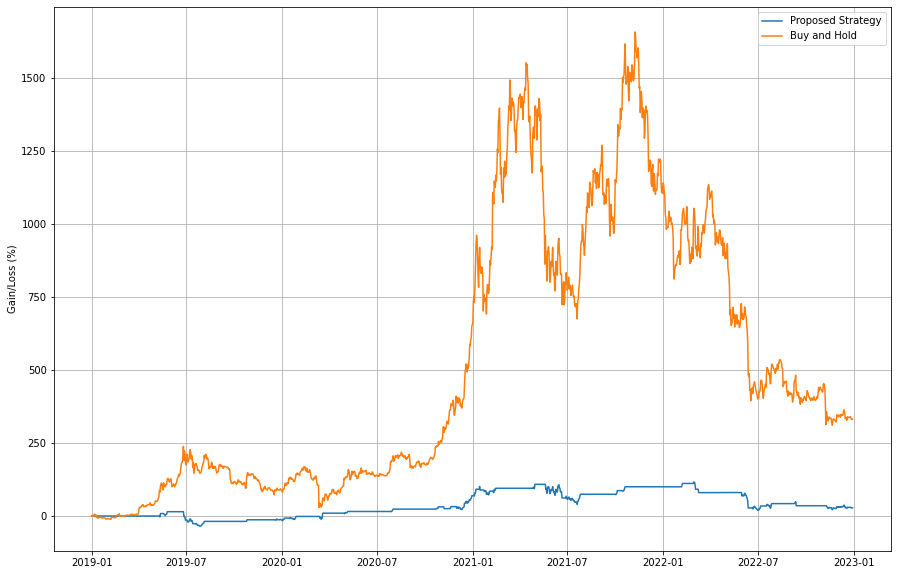

In [57]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.plot(df_btc_close*100/df_btc_close.iloc[0] - 100, label="Buy and Hold")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Gain/Loss (%)')

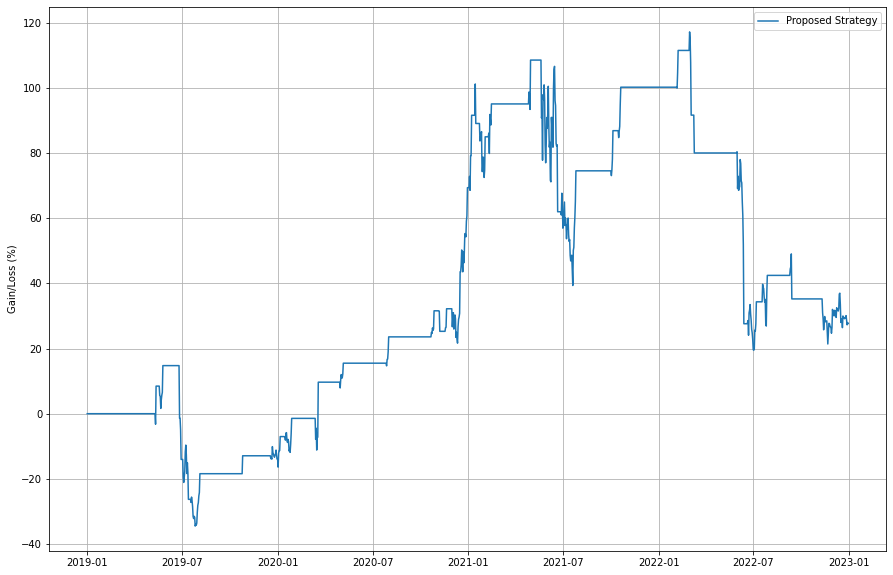

In [58]:
plt.figure(figsize=(15,10))
plt.plot(port_size*100/1_000_000 -100, label="Proposed Strategy")
plt.legend()
plt.grid()
plt.ylabel("Gain/Loss (%)")

Text(0, 0.5, 'Port Size (USD)')

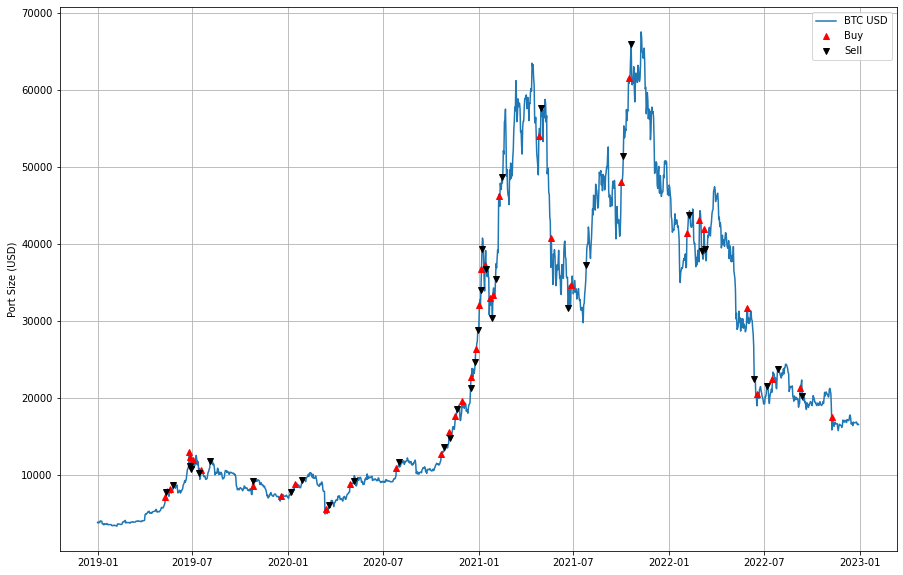

In [59]:
plt.figure(figsize=(15,10))
Buys = df_btc_close[actions==1]
Sells = df_btc_close[actions==-1]
plt.plot(df_btc_close, label="BTC USD")
plt.plot(Buys, label="Buy", marker="^", color="red", linestyle = 'None')
plt.plot(Sells, label="Sell", marker="v", color="black", linestyle = 'None')
plt.legend()
plt.grid()
plt.ylabel("Port Size (USD)")

In [61]:
def getPeformanceValue(port_size:pd.Series):
  total_return = (port_size.iloc[-1]/port_size.iloc[0] - 1)
  peak = port_size.max()
  max_date = port_size.index[port_size==peak]
  max_date = max_date.min()
  filtered_port_size = port_size[max_date:]
  mdd = 1.0 - filtered_port_size.min()/peak
  port_return = port_size.pct_change(1).dropna()
  sharpe_ratio = port_return.mean()/ port_return.std()
  sharpe_ratio *= np.sqrt(365) # scale to annum
  return total_return, mdd, sharpe_ratio

total_return, mdd, sharpe_ratio =  getPeformanceValue(port_size)
print(f"The perfomance values of my strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")

total_return, mdd, sharpe_ratio =  getPeformanceValue(df_btc_close)
print(f"The perfomance values of buy and hold strategy are: ")
print(f"    Total Return: {total_return*100:0.2f}%")
print(f"    Maximum Drawn Down: {mdd*100:0.2f}%")
print(f"    Sharpe Ratio: {sharpe_ratio:0.3f}")


The perfomance values of my strategy are: 
    Total Return: 27.67%
    Maximum Drawn Down: 45.00%
    Sharpe Ratio: 0.350
The perfomance values of buy and hold strategy are: 
    Total Return: 331.96%
    Maximum Drawn Down: 76.63%
    Sharpe Ratio: 0.877


# Main Question:
You will trade on less volatile security, namely, Gold future. Find the best strategy to trade on Gold Future from 2019-01-01 to 2022-12-31
Score will be based on
 1. 10 Points to the highest total return at end of 2022.
 2. 10 Points to the lowest maximum drawn down
 3. 10 Points to the highest Sharpe Ratio
 4. 20 Points if you will over the buy and hold strategy in the total return.
 5. 50 Points for the code and the explanation on the strategy

Here, I will rank each scores from the best to the worst where the best get 10 points and worst get 0. If there are more than one people on the same sport both with fill the lower rank.

For example, if all students get the same return, all will be set at the lowest rank (0 Points).

You can use any of these models, ARIMA, or ARIMA + ARCH or ARIMA + GARCH

In [ ]:
df_gold = yf.download("GC=F", start="2019-01-01", end="2022-12-31")
df_gold_close = df_gold.Close

## 1. Report Your Performance Here
 
*   Total_return: _______ %
*   Maximum Draw Down: ________%
*   Sharpe Ration: ________



 
